In [82]:
# Data handling and computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

import string

# Model selection and validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Pipeline library for efficient workflow
from sklearn.pipeline import Pipeline, make_pipeline

# Metrics libraries for evaluating model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn import metrics

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


In [83]:
# Read in data locally
df = pd.read_csv('data/Tweets.csv', encoding='latin1')

# Read in data using google colab/drive
# df = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/tweets.csv', encoding='latin1')

In [84]:
numerical_features = list(df.select_dtypes("number"))
categorical_features = list(df.select_dtypes("object"))

print(f'Numerical Columns: \n{numerical_features}\n')
print(f'Categorical Columns: \n{categorical_features}')

Numerical Columns: 
[]

Categorical Columns: 
['tweet_text', 'emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']


## EDA

In [85]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [87]:
df.nunique().sort_values(ascending=True)

is_there_an_emotion_directed_at_a_brand_or_product       4
emotion_in_tweet_is_directed_at                          9
tweet_text                                            9065
dtype: int64

In [88]:
df.isna().sum().sort_values(ascending=False)

emotion_in_tweet_is_directed_at                       5802
tweet_text                                               1
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [89]:
# df.corr()


## Data Cleaning

In [90]:
# Lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# Renaming columns to better reflect the data
rename_cols = {
      'tweet_text': 'tweet',
      'emotion_in_tweet_is_directed_at': 'tweet_is_directed_at',
      'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
              }
df = df.rename(columns=rename_cols)


# rename values in the 'emotion' column
rename_values = {
      'no emotion toward brand or product': 'no emotion',
      'positive emotion': 'positive',
      'negative emotion': 'negative',
      "i can't tell": 'unsure'
              }
df['emotion'] = df['emotion'].map(rename_values)


# Dropping (1) single row from df['tweet_text']
df.dropna(subset='tweet', inplace=True)


# Filter out 17 tweets that contain both Apple & Google
apple_and_google = ~((df['tweet_is_directed_at'].isna()) &
                   (df['tweet'].str.contains('google')) &
                   (df['tweet'].str.contains('apple')))
df = df[apple_and_google]



## Create assert statements to confirm the code achieved its goals:

assert df.loc[(df['tweet_is_directed_at'].isna()) & (df['tweet'].str.contains('google')) & (df['tweet'].str.contains('apple')), 'tweet'].empty


## Feature Engineering

In [91]:
# Create column of with the character length of the tweet
df['character_count'] = df['tweet'].apply(len)


# Create column of with the word count of the tweet
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))


# Creat column to determine if the tweet was negative toward a brand or not
df['is_tweet_negative'] = df['emotion'].apply(lambda x: 1 if x == 'negative' else 0 if x == 'positive' else 2)

# What company is the tweet about?
renamed_values = {
      'ipad': 1, 'ipad or iphone app': 1,
      'iphone': 1, 'other google product or service': 0,
      'android app': 0, 'android': 0, 'google': 0,
      'other apple product or service': 1, 'apple': 1,
                 }
df['is_apple'] = df['tweet_is_directed_at'].map(renamed_values).astype('Int64')


# Creating a feature call 'number_of_mentions' to count @mentions
df['number_of_mentions'] = df['tweet'].str.count('@\w+')


# Create a feature 'hashtags_count' to count hashtags
df['hashtags_count'] = df['tweet'].str.count('#')


# Create feature named 'average_word_length'
df['average_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]))


## Data Filtering

In [92]:
# Assigning unknown tweet to company based on 'apple_words'
apple_words = ['apple', 'iphone','ipod','ipad', 'i-pad', 'app store', 'itunes']
apple_regex = '|'.join(apple_words)  # creates the string 'apple|iphone|ipod|ipad|i-pad'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(apple_regex, case=False), 'is_apple'] = 1


# Assigning unknown tweet to company based on 'google_words'
google_words = ['google', 'android','pixel', 'google play']
google_regex = '|'.join(google_words)  # creates the string 'google|android|pixel|google play'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(google_regex, case=False), 'is_apple'] = 0


# Dropping tweets that have no mention of either Apple or Google
df.dropna(subset=['is_apple'], inplace=True)


# Drop the column 'tweet_is_directed_at' due to many missing values
#df = df.drop(columns=['tweet_is_directed_at'])

In [93]:
df['is_apple'].value_counts()

is_apple
1    5567
0    2802
Name: count, dtype: Int64

In [94]:
df['is_tweet_negative'].value_counts()

is_tweet_negative
2    4833
0    2967
1     569
Name: count, dtype: int64

## Modeling

In [95]:
# You might need to download these if you haven't already
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/llakes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/llakes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [96]:
# Function to preprocess tweets
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s@#]', ' ', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = tweet.split()
    tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in stop_words]
    tweet = ' '.join(tweet)
    return tweet


In [97]:
# Apply preprocessing function to tweets
df['processed_tweet'] = df['tweet'].apply(preprocess)

In [98]:
# Feature extraction with TF-IDF
# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_tweet']).toarray()
y = df['is_tweet_negative']

In [99]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [100]:
# Print the original class distribution
print('Original class distribution: \n', y_train.value_counts())

Original class distribution: 
 is_tweet_negative
2    3868
0    2364
1     463
Name: count, dtype: int64


In [101]:
# Handle imbalance class using SMOTE only on the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [102]:
# Print the resampled class distribution
print('Resampled class distribution: \n', y_train_smote.value_counts())

Resampled class distribution: 
 is_tweet_negative
0    3868
2    3868
1    3868
Name: count, dtype: int64


In [103]:
# Train the model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.48      0.55       603
           1       0.72      0.12      0.21       106
           2       0.68      0.85      0.76       965

    accuracy                           0.67      1674
   macro avg       0.68      0.49      0.51      1674
weighted avg       0.67      0.67      0.65      1674

Accuracy: 0.6732377538829152


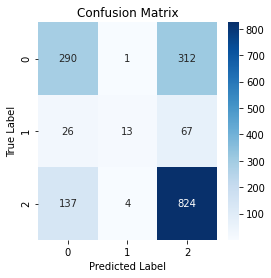

              precision    recall  f1-score   support

           0       0.64      0.48      0.55       603
           1       0.72      0.12      0.21       106
           2       0.68      0.85      0.76       965

    accuracy                           0.67      1674
   macro avg       0.68      0.49      0.51      1674
weighted avg       0.67      0.67      0.65      1674

Accuracy: 0.6732377538829152


In [104]:
# Generate confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

## More preprocessing

In [105]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [106]:
punctuation = '"$%&\'()*+,-./:;<=>[\\]^_`{|}~'

In [107]:
df

,tweet,tweet_is_directed_at,emotion,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length,processed_tweet
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iphone,negative,127,23,1,1,1,2,4.521739,@wesley83 3g iphone 3 hr tweeting #rise_austin...
1,@jessedee know about @fludapp ? awesome ipad/i...,ipad or iphone app,positive,139,22,0,1,2,1,5.363636,@jessedee know @fludapp awesome ipad iphone ap...
2,@swonderlin can not wait for #ipad 2 also. the...,ipad,positive,79,15,0,1,1,2,4.333333,@swonderlin wait #ipad 2 also sale #sxsw
3,@sxsw i hope this year's festival isn't as cra...,ipad or iphone app,negative,82,15,1,1,1,1,4.533333,@sxsw hope year festival crashy year iphone ap...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,google,positive,131,17,0,0,1,1,6.764706,@sxtxstate great stuff fri #sxsw marissa mayer...
...,...,...,...,...,...,...,...,...,...,...,...
9088,ipad everywhere. #sxsw {link},ipad,positive,29,4,0,1,0,1,6.500000,ipad everywhere #sxsw link
9089,"wave, buzz... rt @mention we interrupt your re...",NaN,no emotion,125,18,2,0,1,3,5.944444,wave buzz rt @mention interrupt regularly sche...
9090,"google's zeiger, a physician never reported po...",NaN,no emotion,145,19,2,0,0,2,6.684211,google zeiger physician never reported potenti...
9091,some verizon iphone customers complained their...,NaN,no emotion,140,23,2,1,0,1,5.086957,verizon iphone customer complained time fell b...


In [108]:
df['tweet'] = [s.translate(str.maketrans('', '', punctuation)) for s in df['tweet']]

In [109]:
df

,tweet,tweet_is_directed_at,emotion,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length,processed_tweet
0,@wesley83 i have a 3g iphone after 3 hrs tweet...,iphone,negative,127,23,1,1,1,2,4.521739,@wesley83 3g iphone 3 hr tweeting #rise_austin...
1,@jessedee know about @fludapp ? awesome ipadip...,ipad or iphone app,positive,139,22,0,1,2,1,5.363636,@jessedee know @fludapp awesome ipad iphone ap...
2,@swonderlin can not wait for #ipad 2 also they...,ipad,positive,79,15,0,1,1,2,4.333333,@swonderlin wait #ipad 2 also sale #sxsw
3,@sxsw i hope this years festival isnt as crash...,ipad or iphone app,negative,82,15,1,1,1,1,4.533333,@sxsw hope year festival crashy year iphone ap...
4,@sxtxstate great stuff on fri #sxsw marissa ma...,google,positive,131,17,0,0,1,1,6.764706,@sxtxstate great stuff fri #sxsw marissa mayer...
...,...,...,...,...,...,...,...,...,...,...,...
9088,ipad everywhere #sxsw link,ipad,positive,29,4,0,1,0,1,6.500000,ipad everywhere #sxsw link
9089,wave buzz rt @mention we interrupt your regula...,NaN,no emotion,125,18,2,0,1,3,5.944444,wave buzz rt @mention interrupt regularly sche...
9090,googles zeiger a physician never reported pote...,NaN,no emotion,145,19,2,0,0,2,6.684211,google zeiger physician never reported potenti...
9091,some verizon iphone customers complained their...,NaN,no emotion,140,23,2,1,0,1,5.086957,verizon iphone customer complained time fell b...
